# Hierarchical Gaussian Filter model - Demo
The model was implemented following the paper of *Mathys, C. D., Lomakina, E. I., Daunizeau, J., Iglesias, S., Brodersen, K. H., Friston, K. J., & Stephan, K. E. (2014). Uncertainty in perception and the Hierarchical Gaussian Filter. Frontiers in human neuroscience, 8, 825.*.
Default configuration settings (**hgf_config**) were taken from the original Matlab implementation by C.D. Mathys.

This Notebook serves as a quick introduction in how the functions can be loaded, altered and displayed.

## First we set everything up
#### Import some background function

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

from IPython.core.pylabtools import figsize
%matplotlib inline

#### Import the hgf - fit, simulate, and pressentation functions
(function .py files should be located in the same folder [or it should be specified])

In [2]:
# import fit and sim models from the hgf
from Prediction.HGF import hgf_fit
from Prediction.HGF import hgf_sim

# import the presentation functions for plotting and storing
from Prediction.HGF import hgf_pres

# load our configuration functions
from Prediction.HGF.hgf_config import *
from Prediction.HGF.hgf import *

## - Continuous Scale Stimuli -
## set up some kind of sequence
here we probabilistically sample from from a binominal distribution to get a interesting sequence that can be centered around two averages

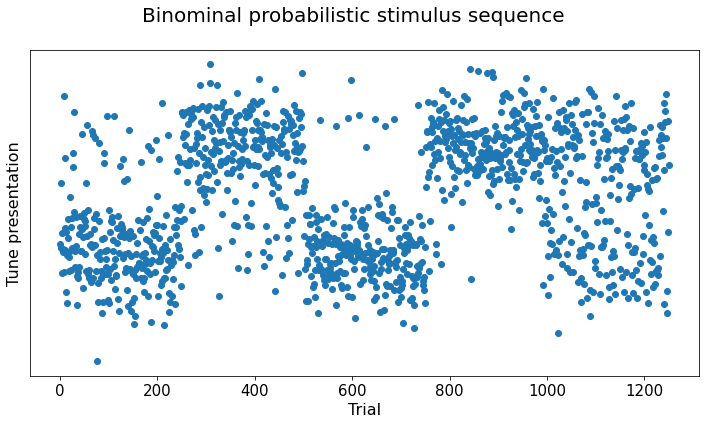

In [3]:
# set trials per blocks and number of blocks
n_blocks = 5
tpb = 250

# methed of how to jitter
jitter_method = 'gaussian'   # jitter method: gaussian, or uniform, or False
jitter_amount = 1

# set probabilities of A - B
probz = [0.5, 0.125, 0.03125, 0.875, 0.96875]
stim_values = [4, 8]

# create array to sture stimuli
stims = np.empty(n_blocks * tpb)
trails = np.arange(1, len(stims)+1)

# shuffle probability of accurence in block
random.seed(123)
random.shuffle(probz)

# loop over block and set 
for i in range(n_blocks):
    # set our probailistic numbers 
    stims[i*tpb:(i*tpb)+tpb] = np.random.choice(stim_values, tpb, p=[probz[i], 1-probz[i]])
    # add jitter
    if jitter_method == 'gaussian':
        stims[i*tpb:(i*tpb)+tpb] += np.random.normal(0, jitter_amount, size=tpb)
    elif jitter_method == 'uniform':
        stims[i*tpb:(i*tpb)+tpb] += np.random.uniform(0, jitter_amount, size=tpb)
        
# and plot
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(trails, stims)

plt.suptitle('Binominal probabilistic stimulus sequence',fontsize=20);
plt.xlabel('Trial', fontsize=16)
plt.ylabel('Tune presentation', fontsize=16)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
ax.axes.yaxis.set_ticks([]);

## Fit the HGF model

Herefor we use the `hgf_fit.fitModel()` function.
In this case, for more robust result we rely on the `ehgf_config` (enhanced hgf) configuation function.

*note. for sequences that have two possible outcomes (binary out), you should rely on the **binary** equivalent (e.g. hgf_binary_config, or ehgf_binary_config)*

In [4]:
r = hgf_fit.fitModel([],
                     stims,
                     ehgf_config,
                     bayes_optimal_config, 
                     quasinewton_optim_config)

Ignored trials: []
Irregular trials: []

Initializing optimization run...

Optimization terminated successfully.
         Current function value: 2446.874472
         Iterations: 29
         Function evaluations: 252
         Gradient evaluations: 36


RESULTS:

Parameter estimates - perceptual model:
 mu_0: 	 [4.76734651 1.        ]
 sa_0: 	 [1.08558821 0.01478111]
 rho: 	 [0. 0.]
 ka: 	 [1.]
 om: 	 [-2.2208925]
 th: 	 4.370767415880788e-06
 pi_u: 	 0.037509793969685255
 al: 	 26.659703884488998

MODEL QUALITY:
 LME: 	 -2449.9021907933566 		 (more is better)
 AIC: 	 4881.469217508346 		 (less is better)
 BIC: 	 4887.332497550999 		 (less is better)


#### what does this offer us?
* first of the optimization results, model quality and parameter estimates are displayed to give a quick indication of fit quality
* all values / priors / prediction errors are stored within one dictionary that is returned
  * the nested dictionary `r['traj']` discribes the expected trajectory based on the model
  * the nested dictionary `r['optim']` discribes the 'optimal' parameter estimates
  
Parameter estimates represents
* `mu_0`:  initial believes of every level
* `sa_0`:  initial values of perceptual state
* `rho`:   drift parameter
* `ka`:    coupling between levels (can be 1)
* `om`:    stim response parameter

What we get back is
* `muhat` : prediction
* `sahat` : 1/pi, representations
* `v` : weighting factor
* `w` : weighting factor
* `da` : volatility of prediction error
* `dau` : pred error input
* `ud` : updates with respect to prediction
* `psi` : precision weights (on prediction errors)
* `epsi` : prediction errors weighted by precision
* `wt` : full learning rate

## Simulate using our HGF model
Next we use the `hgf_sim.simModel()` function to similate predictions using priors and intergrating current information.
* We implement an array with parameter values **[mu_0(lvl1), mu_0(lvl2), sa_0(lvl1), sa_0(lvl2), rho(lvl1), rho(lvl2), ka(lvl1/2), om(lvl1), om(lvl2)]**
  * Of size **[9]** for a 2 level HGF
  * Of size **[14]** for a 3 level HGF
  * Of size **(5 x n)-1** for n level HGF

In [5]:
pvec_now = np.array([6, 0.10, 0.001, -0.01, 0, 0, 0.05, 1.2,  2.5, 0.5]) 
# pvec_now = np.array([1.04, 1, 0.0001, 0.1, 0, 0, 1, -13,  -2, 1e4])

sim = hgf_sim.simModel(stims, hgf, 
                       pvec_now,
                       obs_model=gaussian_obs,
                       obs_pvec=0.00002)

Ignored trials: []


KeyError: <function hgf at 0x7fc008a87dc0>

### We can then put all the usefull information into a pandas dataframe and plot the results
* `hgf_pres.constructDataframe()` is used to put all the estimates and simulation into a pd dataframe
* `hgf_pres.plot_expect()` is used to plot expectation of input level and higer level
* `hgf_pres.plot_learningrate()` is used to plot the learning rate 

In [6]:
df = hgf_pres.constructDataframe(r,sim)
hgf_pres.plot_expect(df, sim, pres_post=True)

NameError: name 'sim' is not defined

In [7]:
# and learning rates
hgf_pres.plot_learningrate(df, alpha_mu=0.05)

NameError: name 'df' is not defined

### We can use our simulated expectation and put them back in our model 
This way we can estimate the parameter values for our simulated data.

In [8]:
r = hgf_fit.fitModel(sim['y'],
                     stims,
                     ehgf_config,
                     bayes_optimal_config, 
                     quasinewton_optim_config)

NameError: name 'sim' is not defined

<AxesSubplot:>

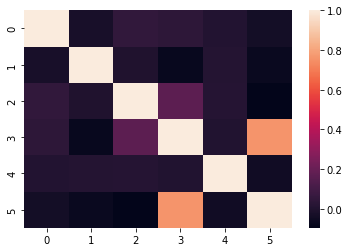

In [9]:
sns.heatmap(r['optim']['Corr'])

After this you may want to check identifiability of parameters (by looking at their posterior correlation). This would indicate what the effect is of changing one variable, and how other variables compensate. A complete correlation (of 1 or -1) would be bad as it would indicate that changing one parameter is fully equivalent to changing antother (in the case of -1 in the other direction).

+ if this is the case, parameters can not be identiefied independently and one of them needs to be fixed!

Here everything seems fine!

In [10]:
# as a senaty check we can also check this
df = hgf_pres.constructDataframe(r,sim)
hgf_pres.plot_expect(df, sim, pres_post=True)

NameError: name 'sim' is not defined

## Add a(n) extra(s) level - (3 options)
* For similuations we can just add the appropriate number of parameters in `pvec` and the number of levels will be adjusted automatically. 
* Or we can implement a custom extra level fit by setting it in a dictionary to overwrite some or all of the settings (see later)
* Or we can use a `xxx_config` with a higher number of levels in it (personal config functions can be easily created)

First we simply change the `pvec` amount (only works for simulation)

In [11]:
# Like before we set pvec, but this time we use more parameters to indicate we have 3 levels (14 parameters)
pvec_now = np.array([7, 0.1, 1.0, 0.001, -0.001,
                     -0.1, 0, 0, 0,
                     0.08, 0.12, 0.12,
                     3.6, 0.5, 0.5]) 

sim = hgf_sim.simModel(stims, hgf, 
               pvec_now,
               obs_model=gaussian_obs,
               obs_pvec=0.00005)

Ignored trials: []


KeyError: <function hgf at 0x7fc008a87dc0>

#### Altering config settings
Alternatively we can just put everything withing a dictonary with just the settings we want to change.
This method works for both `fit` and `sim`

In [12]:
# create dict with our settings
c = {}
c['c_prc'] = {}

# set our number of levels
c['c_prc']['n_levels']   = 3

# define the priors for all levels
c['c_prc']['mu_0mu'] = np.array([99991, 1, 1])
c['c_prc']['mu_0sa'] = np.array([99992, 0, 0])
c['c_prc']['logsa_0mu'] = np.array([99993, np.log(0.1), np.log(0.1)])
c['c_prc']['logsa_0sa'] = np.array([1, 1, 1])

c['c_prc']['rhomu'] = np.array([0, 0, 0])
c['c_prc']['rhosa'] = np.array([0, 0, 0])
c['c_prc']['logkamu'] = np.array([np.log(1), np.log(1)])
c['c_prc']['logkasa'] = np.array([0, 0])

c['c_prc']['ommu'] = np.array([99993, -4, -8])
c['c_prc']['omsa'] = np.array([4**2, 4**2, 4**2])
c['c_prc']['logpiumu'] = np.array([-99993])
c['c_prc']['logpiusa'] = np.array([2**2])

# gather prior settings in vectors
c['c_prc']['priormus'] = np.concatenate([c['c_prc']['mu_0mu'], 
                                        c['c_prc']['logsa_0mu'], 
                                        c['c_prc']['rhomu'], 
                                        c['c_prc']['logkamu'], 
                                        c['c_prc']['ommu'], 
                                        c['c_prc']['logpiumu']], axis=0)
c['c_prc']['priorsas'] = np.concatenate([c['c_prc']['mu_0sa'], 
                                        c['c_prc']['logsa_0sa'], 
                                        c['c_prc']['rhosa'], 
                                        c['c_prc']['logkasa'], 
                                        c['c_prc']['omsa'], 
                                        c['c_prc']['logpiusa']], axis=0)

In [13]:
r = hgf_fit.fitModel(sim['y'],
                     stims,
                     hgf_config,
                     gaussian_obs_config, 
                     quasinewton_optim_config,
                     overwrite_opt=c)

NameError: name 'sim' is not defined

### we can then check if our plotting functions again also representing higher levels

/home/jorvhar/miniconda3/envs/hgf_env/lib/python3.8/site-packages/HGF-0.1.1-py3.8.egg/HGF/hgf_pres.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = pd.DataFrame([[np.nan] * len(df.columns)], columns=df.columns).append(df, ignore_index=True)
/home/jorvhar/miniconda3/envs/hgf_env/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jorvhar/miniconda3/envs/hgf_env/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jorvhar/miniconda3/envs/hgf_env/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jorvhar/miniconda3/envs/hgf_env/lib/python3.8/site-package

array([<AxesSubplot:title={'center':'Inputs, Responses, and posterior expectations of input'}, ylabel='μ3'>,
       <AxesSubplot:title={'center':'Inputs, Responses, and posterior expectations of input'}, ylabel='μ2'>,
       <AxesSubplot:title={'center':'Inputs, Responses, and posterior expectations of input'}, xlabel='Trial nr.', ylabel='u, y, s(μ2)'>],
      dtype=object)

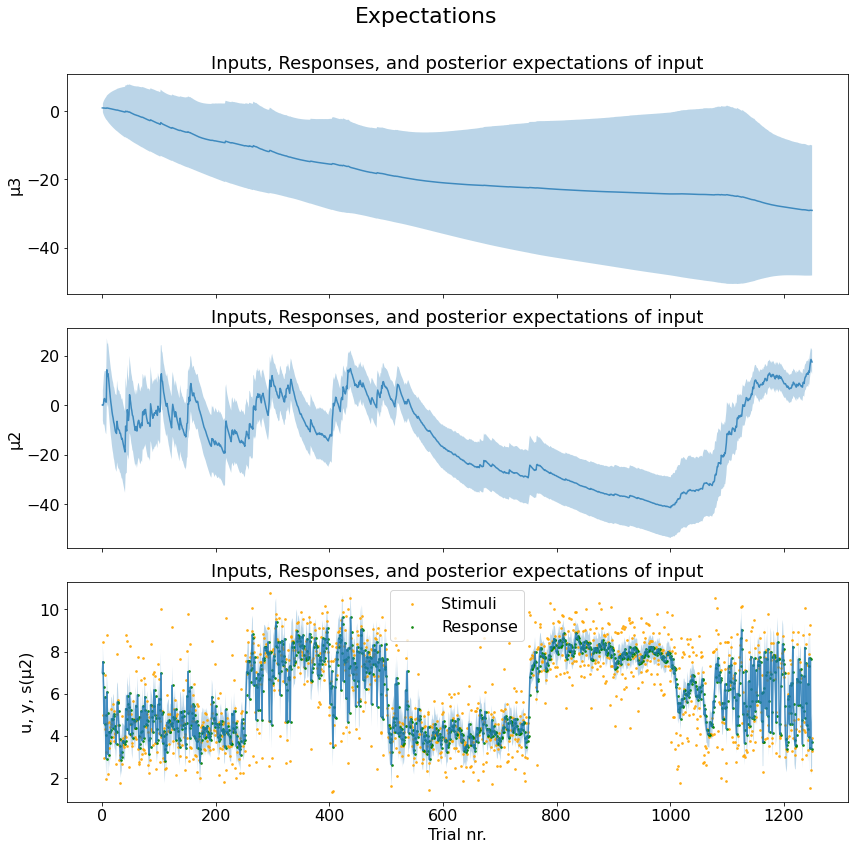

In [14]:
df = hgf_pres.constructDataframe(r,sim)
hgf_pres.plot_expect(df, sim, fit='sim', pres_post=True)

### As well as the precision weights of every level (indicating what these levels capture)
This precision weights captures what every level actually 'learns' from the envrionment. Well defined higher levels can caputre for example higher more global changes in input space. Here the first levels is a quite quick learner where the 3d level captures uncertainty in the environment.

<AxesSubplot:xlabel='Trial nr.', ylabel='Weights'>

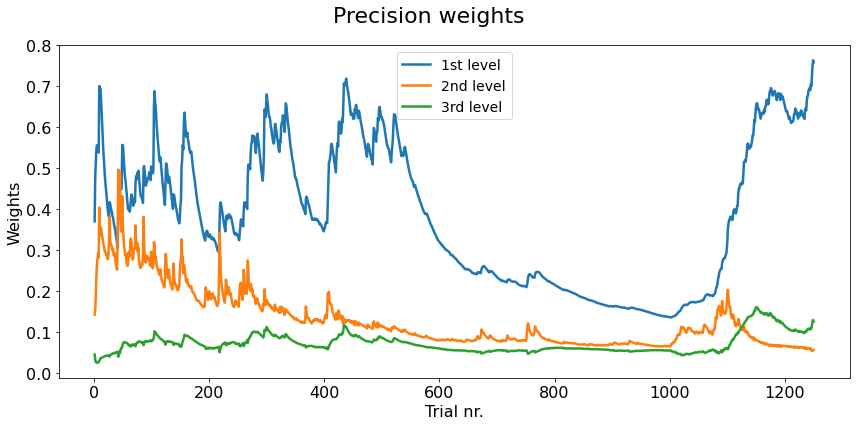

In [15]:
hgf_pres.plot_precision_weights(df, fit='fit')

### Using a residual analyses, to check if our model misses abious structures
checking if the model missed some abious auto correlative effect

array([<AxesSubplot:title={'center':'Residuals time series'}, xlabel='Trial nr.', ylabel='Residuals'>,
       <AxesSubplot:title={'center':'Residuals autocorrelation'}, xlabel='Lag', ylabel='Coeff.'>,
       <AxesSubplot:title={'center':'Scatter residuals vs predictions'}, xlabel='Predictions', ylabel='Residuals'>],
      dtype=object)

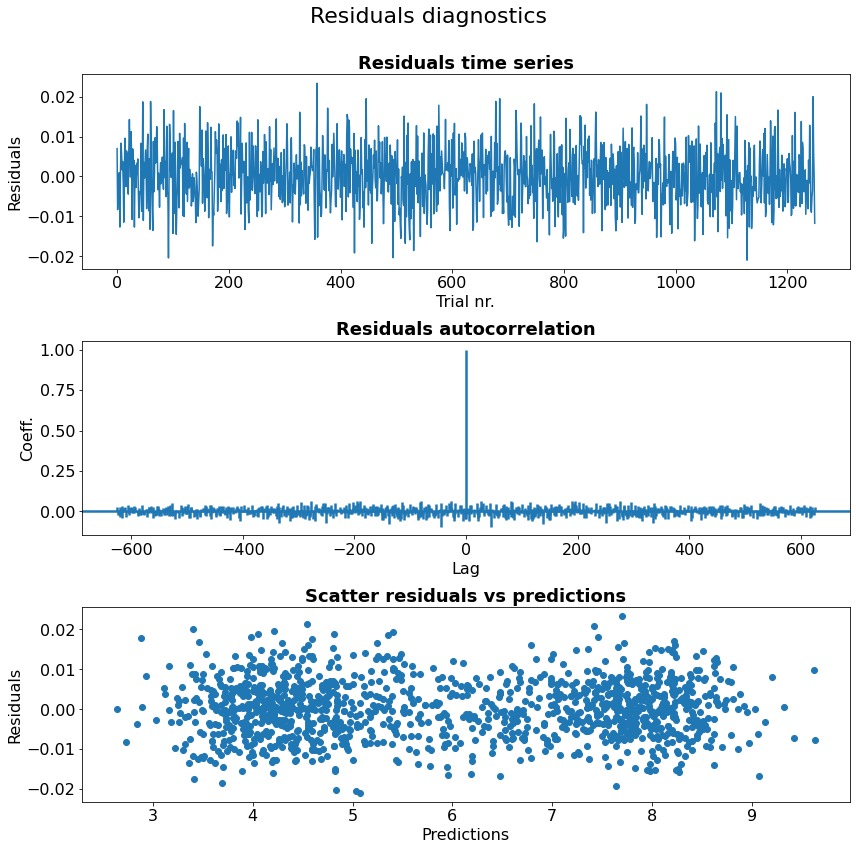

In [16]:
hgf_pres.plot_residualdiag(r)

# - Binary stimuli -
we now move to binary input, very much in line with 2afc probabelistic input.
However, here the input could just be A/B. The HGF moves towards one or the other and behaves in line with a diffusion to bound machanism (however we still employ a precision weight, making the process probabelistic).

In [17]:
stims = np.loadtxt("demo_files/example_binary_input.txt", dtype=float)

We rely again on `hgf_fit.fitModel()`, however, this time we set config files to `_binary_`.
We set responses to [], as we here focus purely on a perceptual model (not on the response model).

In [18]:
r = hgf_fit.fitModel([], stims, per_model=ehgf_binary_config,
                    obs_model=bayes_optimal_binary_config,
                    opt_model=quasinewton_optim_config,
                    overwrite_opt=False)

Ignored trials: []
Irregular trials: []

Initializing optimization run...

Optimization terminated successfully.
         Current function value: 207.820394
         Iterations: 7
         Function evaluations: 27
         Gradient evaluations: 9


RESULTS:

Parameter estimates - perceptual model:
 mu_0: 	 [nan  0.  1.]
 sa_0: 	 [nan 0.1 1. ]
 rho: 	 [nan  0.  0.]
 ka: 	 [1. 1.]
 om: 	 [        nan -3.04994747]
 th: 	 0.716971945831629

MODEL QUALITY:
 LME: 	 -207.55077884875783 		 (more is better)
 AIC: 	 412.5119366185251 		 (less is better)
 BIC: 	 418.6116486330242 		 (less is better)


And again we can simulate responses using `hgf_fit.simModel()`

In [19]:
pvec_now = np.array([np.nan, 0, 1, np.nan, 1, 1, np.nan, 0, 0, 1, 1, np.nan, -2.5, -6]) #-4, 3])
sim = hgf_sim.simModel(stims, ehgf_binary, 
                       pvec_now,
                       obs_model=unitsq_sgm,
                       obs_pvec=5)

Ignored trials: []


/home/jorvhar/miniconda3/envs/hgf_env/lib/python3.8/site-packages/HGF-0.1.1-py3.8.egg/HGF/hgf_pres.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = pd.DataFrame([[np.nan] * len(df.columns)], columns=df.columns).append(df, ignore_index=True)


array([<AxesSubplot:title={'center':'Posterior expectations of x3'}, ylabel='μ3'>,
       <AxesSubplot:title={'center':'Posterior expectations of x2'}, ylabel='μ2'>,
       <AxesSubplot:title={'center':'Inputs, Responses, and posterior expectations of input'}, xlabel='Trial nr.', ylabel='u, y, s(μ2)'>],
      dtype=object)

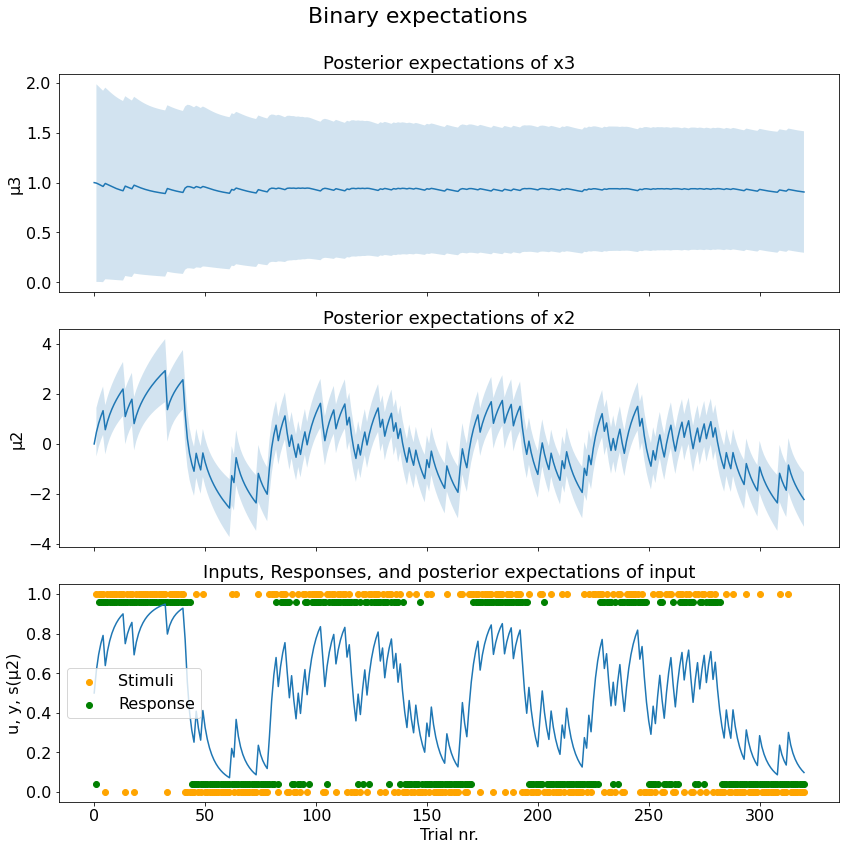

In [20]:
df = hgf_pres.constructDataframe(r,sim)
hgf_pres.plot_binary_expect(df, sim)

array([<AxesSubplot:title={'center':'Inputs, Responses, and posterior expectations of input'}, ylabel='u, y, s(μ2)'>,
       <AxesSubplot:title={'center':'Learning Rate'}, xlabel='Trial nr.', ylabel='lr'>],
      dtype=object)

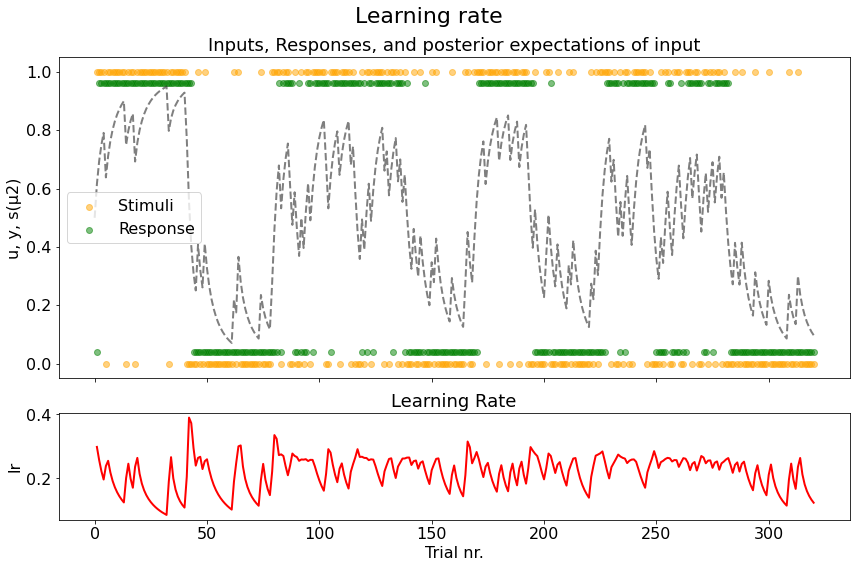

In [21]:
hgf_pres.plot_binary_learningrate(df)

<AxesSubplot:xlabel='Trial nr.', ylabel='Weights'>

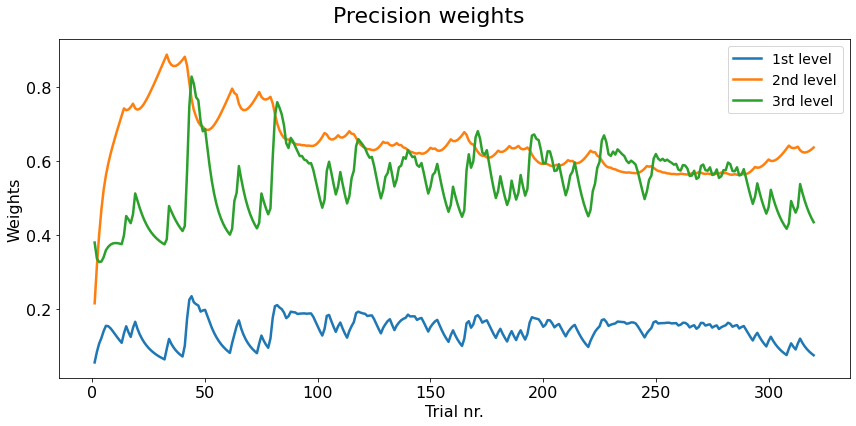

In [22]:
hgf_pres.plot_precision_weights(df, fit='fit')